In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model

from keras.utils import get_file
import cv2

from mrcnn.config import Config

from kerastuner.tuners import Hyperband

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter


C:\Users\EW\AppData\Local\Temp\ipykernel_5468\3644126543.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [78]:
# !pip install keras-tuner --upgrade

In [3]:
# Direktori Dataset
train_dir = 'dataset/train'  
val_dir = 'dataset/test'    

# Image Data Generator untuk Training Data (dengan Augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalisasi pixel antara 0-1
    rotation_range=20,            # Augmentasi rotasi
    width_shift_range=0.2,        # Pergeseran horizontal
    height_shift_range=0.2,       # Pergeseran vertikal
    shear_range=0.2,              # Distorsi
    zoom_range=0.2,               # Zoom
    horizontal_flip=True,         # Membalik horizontal
    fill_mode='nearest'           # Pengisian area kosong
)

# Image Data Generator untuk Validation Data (tanpa Augmentasi)
val_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values

# Data Generator untuk Training Data
train_data = train_datagen.flow_from_directory(
    train_dir,                    # Path to the training data directory
    target_size=(224, 224),      # Ukuran gambar
    batch_size=32,               # Batch size
    class_mode='categorical'     # Kelas dalam format one-hot encoding
)

# Data Generator untuk Validation Data
val_data = val_datagen.flow_from_directory(
    val_dir,                      # Path to the validation data directory
    target_size=(224, 224),      # Ukuran gambar
    batch_size=32,               # Batch size
    class_mode='categorical',     # Kelas dalam format one-hot encoding
    shuffle=False
)


Found 5229 images belonging to 3 classes.
Found 672 images belonging to 3 classes.


Found 5229 images belonging to 3 classes.


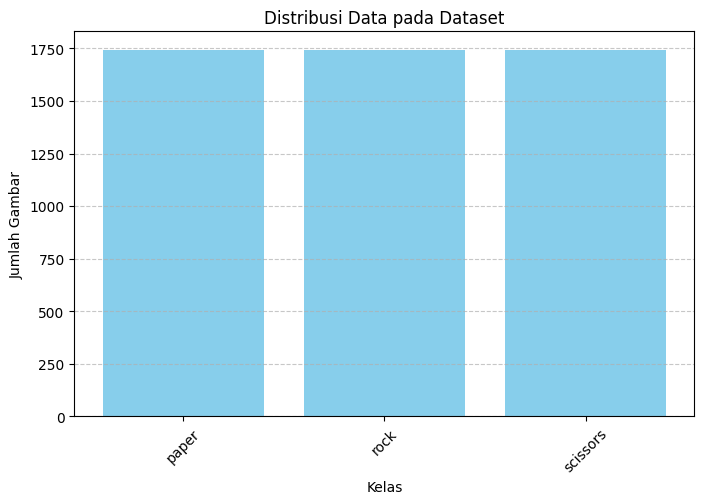

In [11]:
# Inisialisasi ImageDataGenerator untuk dataset
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Memuat gambar dari folder dan membaginya ke dalam batch
data_flow = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Ukuran gambar yang diubah
    batch_size=32,           # Ukuran batch
    class_mode='categorical',  # Karena kita memiliki kategori (rock, paper, scissors)
    shuffle=True             # Gambar akan diacak
)

# Menghitung distribusi dataset
def plot_data_distribution(data_flow):
    # Mengambil daftar kelas dan label
    class_indices = data_flow.class_indices
    classes = list(class_indices.keys())
    
    # Menghitung jumlah instance setiap kelas
    class_counts = Counter(data_flow.classes)
    
    # Memisahkan jumlah untuk plotting
    counts = [class_counts[class_indices[c]] for c in classes]
    
    # Plot distribusi dataset
    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.title("Distribusi Data pada Dataset")
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Memanggil fungsi untuk menampilkan distribusi dataset
plot_data_distribution(data_flow)


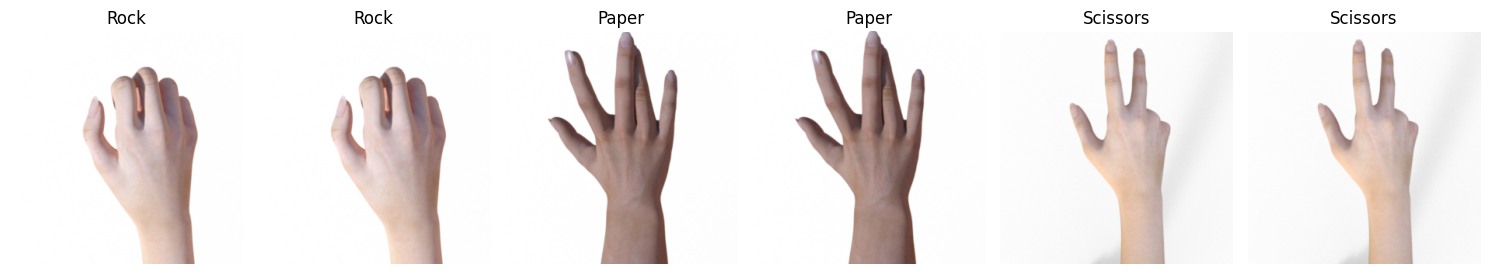

In [20]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Path ke folder dataset
base_path = 'dataset'

# Daftar kategori
categories = ['train/rock', 'train/paper', 'train/scissors']

# Jumlah gambar yang ingin ditampilkan dari masing-masing kategori
num_images = 2

# Buat subplots untuk menampilkan gambar
fig, axes = plt.subplots(1, len(categories) * num_images, figsize=(15, 5))

for idx, category in enumerate(categories):
    images = os.listdir(os.path.join(base_path, category))
    
    for i in range(num_images):
        image_path = os.path.join(base_path, category, images[i])
        image = imread(image_path)
        
        # Menampilkan gambar di subplot
        axes[idx * num_images + i].imshow(image)
        axes[idx * num_images + i].axis('off')
        axes[idx * num_images + i].set_title(os.path.basename(category).capitalize())

plt.tight_layout()
plt.show()


In [81]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Load model MobileNetV2 tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer base model
base_model.trainable = False

# Tambahkan top layer baru
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularisasi tambahan
output = Dense(3, activation='softmax')(x)

# Gabungkan model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Adaptive Moment Estimation

In [83]:
history = model.fit(
    train_data,                   # Generator untuk data pelatihan
    validation_data=val_data,    # Generator untuk data validasi
    epochs=20,
    steps_per_epoch=len(train_data),  # Jumlah batch per epoch
    validation_steps=len(val_data),  # Jumlah batch validasi
    verbose=1,
    callbacks=[early_stopping, reduce_lr],  # Callback untuk early stopping dan LR
    )


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7905 - loss: 0.5237 - val_accuracy: 0.9807 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9462 - loss: 0.1501 - val_accuracy: 0.9643 - val_loss: 0.0851 - learning_rate: 0.0010
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9565 - loss: 0.1198 - val_accuracy: 0.9702 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9659 - loss: 0.0990 - val_accuracy: 0.9807 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9637 - loss: 0.0866 - val_accuracy: 0.9509 - val_loss: 0.1019 - learning_rate: 0.0010
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9707 - loss: 0.0807 - val_accuracy: 0.9777 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9807 - loss: 0.

In [84]:
print("\nEvaluating on Test Data...")
model.evaluate(val_data)


Evaluating on Test Data...
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 704ms/step - accuracy: 0.9869 - loss: 0.0408


[0.03478579595685005, 0.9895833134651184]

21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 632ms/step


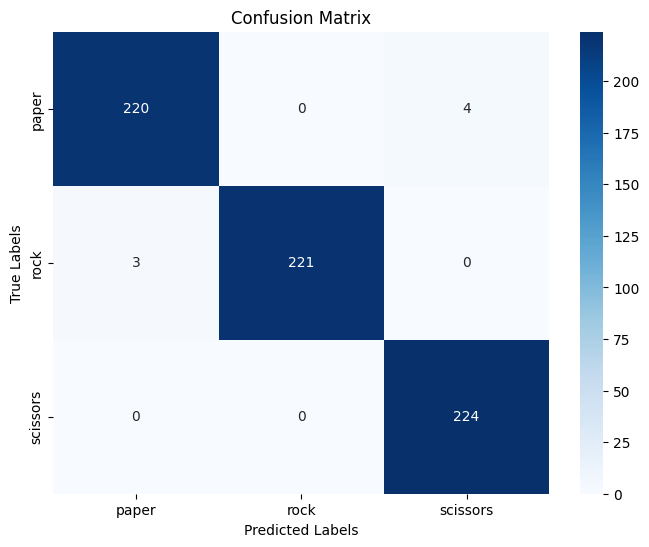


Classification Report:
              precision    recall  f1-score   support

       paper       0.99      0.98      0.98       224
        rock       1.00      0.99      0.99       224
    scissors       0.98      1.00      0.99       224

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672



In [85]:


# Prediksi pada Dataset Testing
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Prediksi kelas
y_true = val_data.classes  # Label sebenarnya

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(val_data.class_indices.keys())  # Nama kelas

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [86]:
model.evaluate(train_data)

164/164 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9897 - loss: 0.0291


[0.02521887980401516, 0.9917766451835632]

In [87]:
model.evaluate(val_data)

21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 738ms/step - accuracy: 0.9869 - loss: 0.0408


[0.03478579595685005, 0.9895833134651184]

In [88]:
# Simpan Model ke File H5
model.save('rock_paper_scissors_model.h5')
print("Model telah disimpan sebagai rock_paper_scissors_model.h5")

Model telah disimpan sebagai rock_paper_scissors_model.h5
